# Quantitative analysis of the rise in college tuition.
Vishnu Nandakumar  
Data 512 Final Project : Code and Report  
University of Washington. Fall '18

### Introduction

The costs for attaining a college degree in the US have increased over the past decade at an alarming rate with far-reaching consequences. According to a recent [report](https://www.studentdebtrelief.us/student-loans/student-debt-statistics/), the student debt hit a total of \$1.52 trillion in 2018, with the average debt per graduate at \$37,172. This is something that is quite unique to the US. Every other country in the world is dwarfed by the statistics shown above. The interesting that I learned about Student Loans in the US is that it has no fixed time frame. Students can spend their entire life paying off their loan. Also, missing payment for just three months can seriously affect the credit score which can further harm their chances of getting a loan for housing or buying a car or even getting a cell phone plan [(source)](https://studentaid.ed.gov/sa/repay-loans/default). It can lead to your wages getting cut without your consent. So for many it is the worst thing that could happen. Now when we consider the increasing default rates and delinquency in the student loans, it paints a bleak picture for the students.<br/>Through the following analysis, I intend to answer the following research questions:

**1. How has the tuition fees risen over the years and what are the factors contributing to it?<br/>**
**2. Is more money being spent on instruction or for other purposes?<br/>**
**3. Is college education becoming unaffordable even with the rising median household income?**

### Motivation

As an international student, I do not have access to federal aids or scholarships. Like a lot of other international students, the entire burden of my education is borne via my parent's life savings and massive education loans in my home country. So I wanted to see why a student in the US has to pay so much and where the revenue from tuition is being spent. That is the central motivation behind this analysis.

### The Analysis

First let us setup the analysis environment. The list of required packages will be listed in the Readme.<br/>
**Note: The code is in Python 3.**

In [3]:
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf

Here I havd defined two utility functions. 
- get_unitids_with_data : The data has a lot of NaN values and that would mean that not all universities would have data on everything. This function takes in the data and the factor we are interested in along with the number of years for which we need the data and also whether to count zero as data as well. It filters the data based on NaN values and returns the list of *unitids*, which is the unique id for each university.<br/>
- adjust_for_inflation: This is utility function takes in the data and the data column as well as the column that corresponds to the cpi index. It returns the data column converted to 2012 \$s.

#### Defining utility functions.

In [12]:
def get_unitids_with_data(data, variable, include_zero=False, min_years=10):
    """
        Finds institute ids that has the variable information for 
        atleast the specified number of years.
    """
    query_str = "{} == {}".format(variable, variable)
    if not include_zero:
        query_str = query_str + " and " + "{} != 0".format(variable)
    #Finding number of years of data for each institute
    grouped_data = data.query(query_str).groupby(["unitid"])["academicyear"].agg("count").reset_index()
    #Returning institute ids that have data for atleast as many years as specified by the user.
    result = grouped_data.query("academicyear >= @min_years")["unitid"].tolist()
    return result

def adjust_for_inflation(data, data_col, index_col="cpi_scalar_2012"):
    """
        Adjusts the current dollars to 2012 dollars.
    """
    return data[data_col] / data[index_col]

#### Reading in the data and creating the raw dataset.

The dataset used here has 974 different attributes. So it is quite difficult to conduct the analysis including all of them. Hence I defined the list of columns I have used in the analysis here to subset the dataset.

In [48]:
#Define the columns of the dataset that will be used.
cols_used = ["academicyear", "unitid", "instname", "sector","state", "tuition02_tf","tuition03_tf", 
            "loan_pct","fall_total_undergrad","total_enrollment" , "federal07", "other05", "tuition_reliance_a2",
             "cpi_scalar_2012", "instruction01", "research01","nettuition_share" ]

#### The Data Source
The dataset I have used is known as the **Delta Cost Project**. It is a comprehensive database containing numerous characteristics of postsecondary educational institutions, especially enrolment and financial related ones. The data tracks the same institutes over the years and hence is an excellent source to examine the trends. The data entire database can be downloaded as a zip file and is divided into two parts by years: 1987-1999 and 2000 to 2012. I could not provide the original files I here as they exceed the github limit of 100 MB. You can download them from [here](https://nces.ed.gov/ipeds/use-the-data/delta-cost-project-finance-data).Please ensure that they are stored in the data folder of your code repository. The data dictionary is also provided in the same location. 

In this analysis, to keep things simple, I have focussed only on four year public institutions. And also the data seemed to be more complete from the year 2000 so I have limited the year range from 2000 till 2012.

In [49]:
#Reading and combining the data.
df1 = pd.read_csv('data/delta_public_87_99.csv', encoding='latin1', usecols=cols_used)
df2 = pd.read_csv('data/delta_public_00_12.csv', encoding='latin1', usecols=cols_used)
df = pd.concat([df1,df2])
# Filtering data to keep only public 4-year institutions and starting from 2000.
df = df.query("sector == 1 and academicyear >= 2000")

In [50]:
df.head(n=5)

,academicyear,unitid,instname,state,sector,cpi_scalar_2012,federal07,other05,tuition_reliance_a2,loan_num,loan_pct,tuition02_tf,tuition03_tf,instruction01,research01,nettuition_share,fall_total_undergrad,total_enrollment
3255,2007,447689,Georgia Gwinnett College,GA,1,0.897054,NaN,NaN,NaN,NaN,NaN,2544.0,10152.0,NaN,NaN,NaN,NaN,NaN
3256,2008,447689,Georgia Gwinnett College,GA,1,0.930292,NaN,91426.0,0.074019,0.0,0.0,NaN,NaN,9813577.0,NaN,0.089466,788.0,NaN
3257,2009,447689,Georgia Gwinnett College,GA,1,0.943282,1574461.0,228574.0,0.148061,40.0,11.0,1190.0,4738.0,11879662.0,18517.0,0.159274,1563.0,1563.0
3258,2010,447689,Georgia Gwinnett College,GA,1,0.952409,5538831.0,76192.0,0.260270,243.0,34.0,2280.0,9048.0,14722723.0,11751.0,0.335847,2947.0,2947.0
3259,2011,447689,Georgia Gwinnett College,GA,1,0.971533,13768197.0,317703.0,0.330035,771.0,48.0,2430.0,9594.0,23027938.0,28168.0,0.432116,5380.0,5380.0


Now since the data is loaded and filtered, let us move on to my first research question.
- **How has the tuition fees risen over the years and what are the factors contributing to it?**

Let us focus on the first part of the question, that is, how tuition has evolved over the years. For that I will be looking at the following variables:
- **tuition02_tf**: Average tuition for instate students.
- **tuition03_tf**: Average tuition for out of state students.

To do calculate the trends, I will be first filtering out the institutions that have the data for those years. And then I will adjust the amounts for inflation  so that they are in 2012 dollars.

In [13]:
# Getting the institution ids that have longitudinal data of atleast 13 years.
instate_unitids = get_unitids_with_data(df,"tuition02_tf",13)
out_of_state_unitids = get_unitids_with_data(df,"tuition03_tf",13)
# Retriveing the data of only those institutes.
instate_df = df.query("unitid in @instate_unitids").copy()
outstate_df = df.query("unitid in @out_of_state_unitids").copy()
# Adjusting the tuition data for inflation and converting to 2012 data.
instate_df["adj_tuition"] = adjust_for_inflation(instate_df, data_col="tuition02_tf")
outstate_df["adj_tuition"] = adjust_for_inflation(outstate_df, data_col="tuition03_tf")

Now I have the adjusted instate and out of state tuitions for each university. Inorder to calculate the average national tuition trend, I group the data by year (the `academicyear` column) and calculate the average the instate and out of state tuition across all universities. 

In [14]:
# Calculating the average instate and out of state tuition by year.
instate_trend = instate_df[["academicyear","adj_tuition"]].groupby("academicyear").mean().rename(
    columns = {"adj_tuition":"Instate Tuition"})
outstate_trend = outstate_df[["academicyear","adj_tuition"]].groupby("academicyear").mean().rename(
    columns = {"adj_tuition":"Out of State Tuition"})
# Merging the two datasets for plotting
trends = instate_trend.merge(outstate_trend, left_index=True, right_index=True)

Now we have the trends store in the `trends` dataframe under column names `Instate Tuition` and `Out of State Tuition`. Plotting those below.

Text(0,0.5,'Inflation adjusted $')

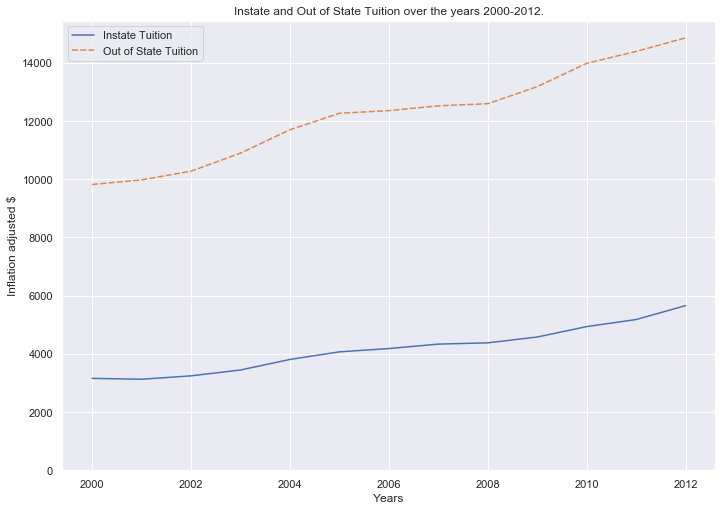

In [15]:
# Plotting the instate and out of state tuitions
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = trends)
ax.set_ylim(0)
ax.set_title("Instate and Out of State Tuition over the years 2000-2012.")
ax.set_xlabel("Years")
ax.set_ylabel("Inflation adjusted $")

We can see that the tuition fees have been on an upward trend for the past decade. There seems to be a small drop in during the 2006 academic year, but again it picked up after 2008. The out of state tuition saw an increase of approx 46% from 2000 to 2012, whereas instate tuitions saw an increase of approx 80%, which is quite astonishing.<br/>

The upward trend that we saw here was inline with what I was expecting. Now moving to the second part of the first question: **Identifying the factors that could have contributed to this trend.**

#### Student Loan
The first factor that I wanted to explore is the trend in the popularity of student loans. I recall reading somewhere that as the interest rates for student loans drops, making them more attractive to students. The idea is that, as more students opt for loans, they don't have to depend too much on their parent's or family's money. This, somehow motivates the Universities to increase their tuition even further. So I would like to examine this claim. 
There is no direct way to examine the popularity of student loans. So as a  proxy, I used the percentage of students on loans as an indicator. The column of interest is `loan_pct`. <br/>
There are a couple of intermediate steps involved here. First I find the total number of undergrad students on loan by multiplying the percentage with the total number of undergrads. Then I find the total number of undergrads on loan year wise across all Universities. Then I calculated the fraction by dividing the number of undergrads on loan with the total number of undergrads enrolled. 

In [16]:
# Finding the universities with complete data and filtering the data for that.
unitids_with_loan = get_unitids_with_data(df,"loan_pct", include_zero=True, min_years=13)
loan_df = df.query("unitid in @unitids_with_loan").copy()
# Finding the count of undergrads on loan 
loan_df["undergrads_on_loan"] = (loan_df["loan_pct"] * loan_df["fall_total_undergrad"]) / 100
# Finding the total count of undergrads on loan and also the total count of undergrads per year
loan_trend = loan_df[["academicyear","undergrads_on_loan","fall_total_undergrad"]].groupby("academicyear").sum()
# Finding the percentage of undergrads on loan by year
loan_trend["Percentage on loan"] =  (loan_trend["undergrads_on_loan"] / loan_trend["fall_total_undergrad"])*100

Plotting the trends.

Text(0,0.5,'% of undergraduates')

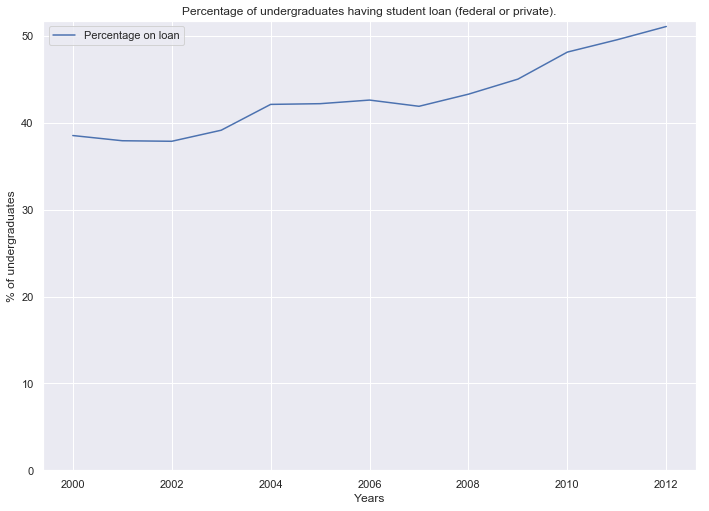

In [31]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = loan_trend[["Percentage on loan"]])
ax.set_title("Percentage of undergraduates having student loan (federal or private).")
ax.set_xlabel("Years")
ax.set_ylim(0)
ax.set_ylabel("% of undergraduates")

So from the graph, we can infer that there an increasing trend in the percentage of undergrad students on loans. More and more students are opting for a student loan to finance their studies. I tried to connect the trends with the actual policy changes such as the decrease in the federal interest rates etc., but I couldn't find the data and the content required for such an in-depth analysis. That is something I would keep as an improvement for future works.

#### Federal grants and aid (Pell grant etc.)

The next factor I wanted to look at was the trend in Federal Aids we received. This includes revenues from federal governmental agencies that are for training programs, research, or public service activities for which expenditures are reimbursable under the terms of a government grant or contract. Includes amount granted for Pell Grants etc.<br/>
The variable from the dataset that I choose for this was `federal07`. The value reported was the gross amount received as federal aid during that academic year. Hence I had to adjust the data to account for inflation. Then I divided the adjusted amount with the total student enrolled to calculate the aid per capita value, which I think would account for the rise in college enrolment as well.

In [28]:
#Finding and filtering out universities with data.
unitids_fed_aid = get_unitids_with_data(df,"federal07", include_zero=True, min_years=13)
aid_df = df.query("unitid in @unitids_fed_aid").copy()

#Adjusting for inflation and also calculating the aid per capita value.
aid_df["adj_aid"] = adjust_for_inflation(aid_df,"federal07") / aid_df["total_enrollment"]

# Finding the average per capita aid per year.
aid_trend = aid_df[["academicyear","adj_aid"]].groupby("academicyear").mean().rename(columns={'adj_aid':'Avg. Federal aid per capita'})

Plotting the trend

Text(0,0.5,'Aid per capita')

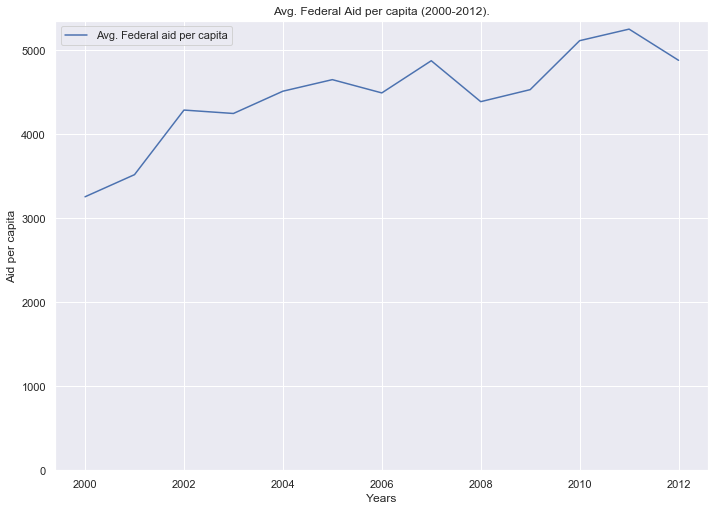

In [32]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = aid_trend[["Avg. Federal aid per capita"]])
ax.set_title("Avg. Federal Aid per capita (2000-2012).")
ax.set_ylim(0)
ax.set_xlabel("Years")
ax.set_ylabel("Aid per capita")

Again we can see that the Federal Aid per capita has been increasing over time, with a slight dip during the 2008 depression. Overall the aid is increasing over time, and so is tuition. My expectation was that Federal Aid helped in controlling the tuition levels to a certain extent. It would be interesting to see if statistically there is any correlation between these two factors after we account for other factors as well.

####  Revenue from other sources

Another factor I thought might affect tuition is the revenue from external sources. Apart from teaching and research Universities also offer services to local government and industry in the form of consultations and other independent operations. Another significant source of income is through the hospitals associated with the University. 
<br/>
<br/> 
To explore the trends in income form other sources I looked at the variable `other05`. It represents the total amount of revenue from hospitals, independent operations, and other sources. My rationale here is that if a Univeristy has a significant external source of income, it could help control the tuition to a certain extent. 
<br/>
The steps involved here are the same. You filter for the universities with complete data (2000-2012), then adjust for inflation. Then find the average revenue per capita per year across all Universities.

In [33]:
#Finding and filtering out universities with complete data on income from other sources.
unitids_other_src = get_unitids_with_data(df,"other05", include_zero=True, min_years=13)
other_src_df = df.query("unitid in @unitids_other_src").copy()
# Adjusting for inflation and calculating revenue per capita
other_src_df["adj_other_src"] = adjust_for_inflation(other_src_df,"other05") / other_src_df["total_enrollment"]
# Calculating the average revenue per capita per year
other_src_trend = other_src_df[["academicyear","adj_other_src"]].groupby("academicyear").mean().rename(columns={'adj_other_src':'Avg. Revenue from other sources(per capita)'})

Text(0,0.5,'Avg. Revenue per capita')

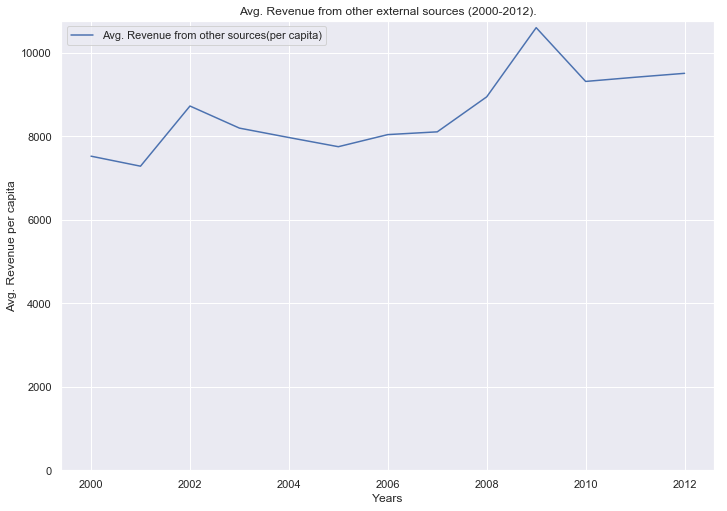

In [34]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = other_src_trend[["Avg. Revenue from other sources(per capita)"]])
ax.set_title("Avg. Revenue from other external sources (2000-2012).")
ax.set_ylim(0)
ax.set_xlabel("Years")
ax.set_ylabel("Avg. Revenue per capita")

Again we see an upward trend in the income from external sources. There seems to be a significant uptick in the between 2008 and 2010, and I suspect this could be related to the dip in federal aid during that same time. The decrease in federal aid could have prompted Universities to seek other sources to meet their expenses.

#### Share of tuition in total revenue

From the above trends, we could see that overall revenue for Universities was increasing over time. But then I would also like to see if the share of revenue from tuition has increased or decreased over time. That could give us an idea about the importance of revenue stream from tuition.<br/><br/>
The variable we would use for this is `tuition_reliance_a2`. It represents the net tuition share of operating revenues from basic revenue streams; sales and services of educational activities; and auxiliary enterprises.
The steps involved here are pretty much straightforward. Finding universities with complete data, then calculating the average share per year across all universities.

In [35]:
#Finding and filtering universities with complete data on share of tuition in total revenue.
unitids_tuition_reliance = get_unitids_with_data(df,"tuition_reliance_a2", include_zero=True, min_years=13)
tuition_reliance_df = df.query("unitid in @unitids_tuition_reliance").copy()
# 
tuition_reliance_trend = tuition_reliance_df[["academicyear","tuition_reliance_a2"]].groupby("academicyear").mean().rename(columns={'tuition_reliance_a2':'Avg. share of Tuiton in operation revenue.'})

Text(0,0.5,'Avg. revenue share by tuition')

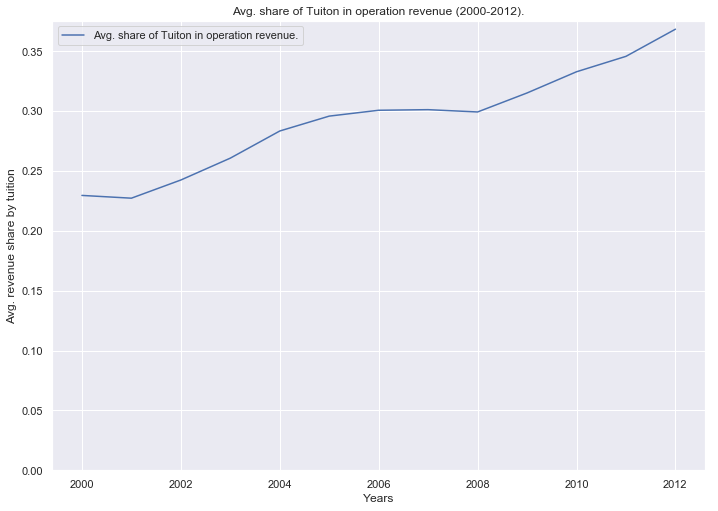

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = tuition_reliance_trend[["Avg. share of Tuiton in operation revenue."]])
ax.set_title("Avg. share of Tuiton in operation revenue (2000-2012).")
ax.set_ylim(0)
ax.set_xlabel("Years")
ax.set_ylabel("Avg. revenue share by tuition")

The trend here is quite interesting to me. There was a rise in the past, which means that the institutions were increasingly relying on tuition. But then starting 2004, it began plateauing, until 2008, where it suddenly picked up again. Given that tuition revenue is not as volatile as the others, it would make sense for the Universities to increase the tuition revenue to increase their stable income. But this is just my speculation, and I guess its time I put everything to the test.

#### Mathematically modeling the avg. tuition cost

I have decided to fit a mixed effects linear regression model on my data to test if the factors I have explored so far have any strength in influencing the tuition cost trends. I chose a mixed effects model because I know that the behavior of each of these factors vary by the state in which those universities are located. Also, each state can have its own random factors and practices that we need to take into account. And the data is in panel form which is ideally suited for such models.
So the clusters will be formed by state and the model will be fit on each cluster separately. Again please note that the data now is at a State level and not university level.

The factors that are considered are: `Avg. Federal Aid per capita, Avg. Income from other sources, Avg. Share of tuition in revenue and Percentage of undergrads having student loans`.

The following steps are involved in creating the analytical dataset for the model:
- Keep only those universities that have data for all the factors being considered.  We can use all the ids found previously while analyzing each factor to find the intersection of all the ids.
- Re-calculate the values for the analytical dataset.

In [38]:
# Find the intersection of all the ids, ie find universities that has data on all factors discussed so far/.
all_unitids = [instate_unitids, out_of_state_unitids, unitids_tuition_reliance, 
               unitids_fed_aid, unitids_other_src, unitids_with_loan]
final_unitids = list(reduce(set.intersection, [set(item) for item in all_unitids ]))

# Subsetting and filtering the data.
analytic_df = df.query("unitid in  @final_unitids").copy()
analytic_df = analytic_df[cols_used]

# Calculating the target variable : avg tuition (asdjusted for inflation)
analytic_df["avg_tuition"] = (analytic_df["tuition02_tf"] + analytic_df["tuition03_tf"]) /2
analytic_df["adj_avg_tuition"] = adjust_for_inflation(analytic_df, "avg_tuition")
# Calculating the inflation adjusted avg aid.
analytic_df["adj_aid"] = adjust_for_inflation(analytic_df,"federal07")
# Calculating the inflation adjusted revenue from other souces.
analytic_df["adj_other_src"] = adjust_for_inflation(analytic_df,"other05")

Calculating the mean of all the factors excluding percentage of tuition share, by State and Year.

In [39]:
# Subsetting and calculating the mean of all the factors by year and state.
final_df = analytic_df[["academicyear", "state", "adj_avg_tuition","adj_aid","adj_other_src","tuition_reliance_a2"]]
final_df = final_df.groupby(["academicyear", "state"]).mean()

Calulating the avg. share of tuition in revenue.

In [40]:
# Calculating the avg. fraction of students having a loan.
analytic_df["undergrads_on_loan"] = (analytic_df["loan_pct"] * analytic_df["fall_total_undergrad"]) / 100
# Finding the total students on loan by year and state.
final_loan_df = analytic_df[["academicyear","state","undergrads_on_loan","fall_total_undergrad"]].groupby(["academicyear","state"]).sum()
# Calculating the precentage having a loan.
final_loan_df["pc_on_loan"] = final_loan_df["undergrads_on_loan"] / final_loan_df["fall_total_undergrad"]

Merged the two datasets to get the final analytical dataset. Saving the file in the data/ folder for easy reproducibility.

In [41]:
final_df = final_df.merge(final_loan_df[["pc_on_loan"]], right_index=True, left_index=True).reset_index()
final_df.to_csv("data/data_for_panel_reg.csv", index=False)

Before we run the model all the data columns needs to be scaled. Linear regressions are known to be affected by using data of different scales, hence it is necessary for us to scale the data to values between 0 and 1. 

In [42]:
# Read in the data
final_df = pd.read_csv("data_for_panel_reg.csv")
# Scale the dataset to balues between 0 and 1.
tmp_data = final_df.drop(["academicyear","state", "adj_avg_tuition"], axis=1).copy() 
tmp_norm = (tmp_data - tmp_data.mean()) / (tmp_data.max() - tmp_data.min())
# Concat the data cols with the rest of the analytical data.
tmp_norm = pd.concat([final_df[["academicyear","state", "adj_avg_tuition"]],tmp_norm], axis=1)

In [44]:
# Peek at the scaled data.
tmp_norm.head()

,academicyear,state,adj_avg_tuition,adj_aid,adj_other_src,tuition_reliance_a2,pc_on_loan
0,2000,AK,6411.606911,0.062019,-0.076942,-0.369194,-0.064827
1,2000,AL,5944.065904,-0.045757,0.082500,-0.120261,-0.105914
2,2000,AR,4860.455050,-0.152601,-0.112751,-0.262245,-0.206859
3,2000,AZ,6277.191672,0.356291,-0.065882,-0.224872,-0.205687
4,2000,CA,5716.255655,0.070027,0.080622,-0.262007,-0.143692


Fitting the model. The following equation forms the basis of our model. The mixed effects are calculated for each state separately, which means that each state will have an intercept. The 0 is added to remove the explicit global intercept. 
$adjavgtuition ~ 0+adjaid +academicyear+adjothersrc + pconloan+tuitionreliancea2$

In [45]:
# Creating the model
md = smf.mixedlm("adj_avg_tuition ~ 0+adj_aid +academicyear+adj_other_src + pc_on_loan+tuition_reliance_a2",
                 tmp_norm, groups=tmp_norm["state"])

In [46]:
# Fitting the model and then printing the summary.
mdf = md.fit()
print(mdf.summary())

                 Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    adj_avg_tuition
No. Observations:      676        Method:                REML           
No. Groups:            52         Scale:                 911836.5972    
Min. group size:       13         Likelihood:            -5671.4016     
Max. group size:       13         Converged:             Yes            
Mean group size:       13.0                                             
------------------------------------------------------------------------
                       Coef.    Std.Err.   z    P>|z|  [0.025    0.975] 
------------------------------------------------------------------------
adj_aid               10483.343 1081.235  9.696 0.000 8364.161 12602.524
academicyear              4.387    0.137 32.057 0.000    4.119     4.655
adj_other_src          2398.060  833.170  2.878 0.004  765.077  4031.042
pc_on_loan             3490.092  561.352  6.217 0.000 2389.861  4590.

In [47]:
y_predict = mdf.fittedvalues
RMSE = np.sqrt(((tmp_norm["adj_avg_tuition"].values-y_predict)**2).values.mean())
RMSE

915.5665311040987

#### The regression results:  
The model converged and gave a decent RMSE score of 915.53. Coming to the coefficients, it seems like all factors I have considered so far are found to be significant predictors by the model. The p-values for all factors are well within the 0.05 limit. So as per the prilimnary results all the factors considered here are in someway or the other contributing to the rise in tuition.<br/>
The model however is quite simple in that I haven't added in any interaction variables. It could be the case that the factors considered here combined might have an effect on tuition. Also I feel like I need to explore even more factors and add them to the model. Maybe they might capture some unexplained variance and help discover more insights.

#### Analysing Expenses
So we have seen how tuition changed in the past decade, and looked at how various factors have also changed over the time. We've also seen that they are significant in deciding the tuition costs. Now I move to my second research question:<br/> <br/>
** Is more money being spend on instruction or for other purposes? **


To begin let us look at the instructional expense trends over time.
#### Instructional expense.
The instruction related data includes expenses of the colleges, schools, departments, and other instructional divisions of the institution and expenses for departmental research and public service that are not separately budgeted. It excludes expenses for academic administration where the primary function is administration (e.g., academic deans). Information technology expenses related to instructional activities are included if the institution separately budgets and expenses information technology resources (otherwise these expenses are included in academic support).  

We will be specifically looking at the instructional expense per capita. For this the variable that we are going to use for this is `instruction01`. We take the gross expenditure on instruction, divide it with the total enrollment count to get expense per capita. Then finally adjust the value for inflation. Then the value is averaged across States and Universities to obtain the average per capita expense on instruction. 

In [51]:
# Keeping only those universities that have complete data.
unitids_inst_exp = get_unitids_with_data(df,"instruction01", include_zero=True, min_years=13)
inst_exp_df = df.query("unitid in @unitids_inst_exp").copy()

# Calculate the instrucrion expense per capita
inst_exp_df["inst_exp_per_capita"] = inst_exp_df["instruction01"] / inst_exp_df["total_enrollment"]

# Account for inflation
inst_exp_df["inst_exp_per_capita"] = adjust_for_inflation(inst_exp_df, "inst_exp_per_capita")

# Calculating the avg. expense per capita by year.
inst_exp_trend = inst_exp_df[["academicyear","inst_exp_per_capita"]].groupby("academicyear").mean().rename(columns={'inst_exp_per_capita':'Avg. instructional expense per capita'})

Text(0,0.5,'Avg. expense per capita')

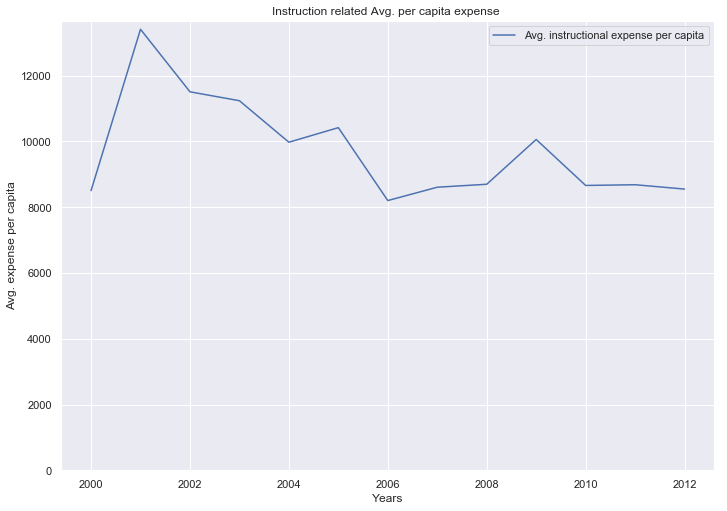

In [52]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = inst_exp_trend[["Avg. instructional expense per capita"]])
ax.set_title("Instruction related Avg. per capita expense ")
ax.set_ylim(0)
ax.set_xlabel("Years")
ax.set_ylabel("Avg. expense per capita")

The graph paints quite an interesting picture. The expense per capita of instruction-related activities has not changed much in the past decade. Definitely makes one think where all the money is going, doesn't it? 
Also, this makes me curious about how much money is being spent on research.

#### Research expense

Research expense includes expenses for activities specifically organized to produce research outcomes and commissioned by an agency either external to the institution or separately budgeted by an organizational unit within the institution. It comprises of institutes and research centers, and individual and project research.

The variable we are using here is `research01`. The steps followed to calculate research expense per capita is same as those followed previously for calculating instructional expense per capita.

In [53]:
# Keeping only those universities that have complete data.
unitids_res_exp = get_unitids_with_data(df,"research01", include_zero=True, min_years=13)
res_exp_df = df.query("unitid in @unitids_res_exp").copy()

# Calculate the research expense per capita
res_exp_df["res_exp_per_capita"] = res_exp_df["research01"] / res_exp_df["total_enrollment"]

# Adjusting for inflation
res_exp_df["res_exp_per_capita"] = adjust_for_inflation(res_exp_df, "res_exp_per_capita")

# Calculating the avg. expense per capita by year.
res_exp_trend = res_exp_df[["academicyear","res_exp_per_capita"]].groupby("academicyear").mean().rename(
    columns={'res_exp_per_capita':'Avg. research expenditure per capita'})

Text(0,0.5,'Avg. expense per capita')

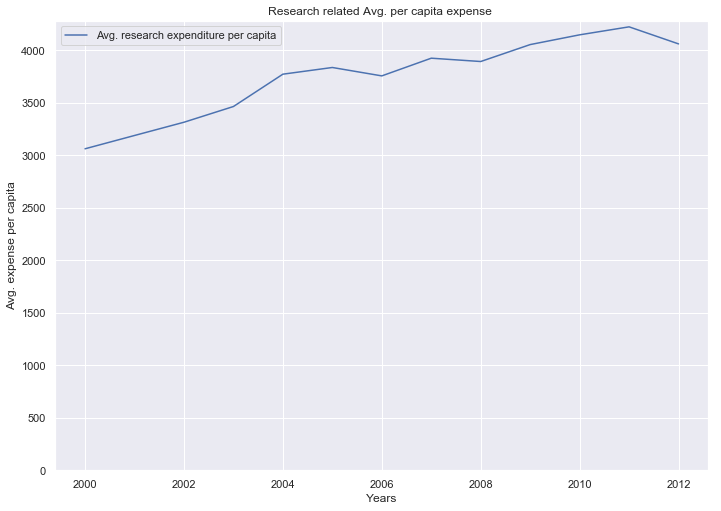

In [54]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = res_exp_trend[["Avg. research expenditure per capita"]])
ax.set_title("Research related Avg. per capita expense ")
ax.set_ylim(0)
ax.set_xlabel("Years")
ax.set_ylabel("Avg. expense per capita")

Here we see that the expenditure related to research are increasing quite steadily. So this means that the stationary trend we observed for instructional expenditures is unique and is quite difficult to explain. One reason why I think we are seeing this is that the instruction domain is not witnessing any sort of drastic changes so to speak. Research on the other hand, is constantly evolving and is given more importance. More research is being funded and programs getting established. So if that is the case, it is quite unfortunate that current system considers instruction secondary to research.

#### Share of instructional expense from tuition revenue

Finally I wanted to look at what portion of instructional expense is being met through the revenue from tuition. It would give an idea if the students money are being spent on them or not. For calculating this trend I am using the variable `nettuition_share`. It is a derived varible. It represents the share of education and related expenses that are covered by net tuition revenue.

In [55]:
# Keeping only those universities that have complete data. 
unitids_tuition_share = get_unitids_with_data(df,"nettuition_share", include_zero=True, min_years=13)
share_exp_df = df.query("unitid in @unitids_tuition_share").copy()

# Subsetting the data
share_exp_df = share_exp_df[["academicyear", "nettuition_share"]]

# Calculating the avg. share by year.
share_exp_trend = share_exp_df.groupby("academicyear").mean().rename(
    columns={'nettuition_share':'Educational expense share covered by tuition'
            })

Text(0,0.5,'Share of expense.')

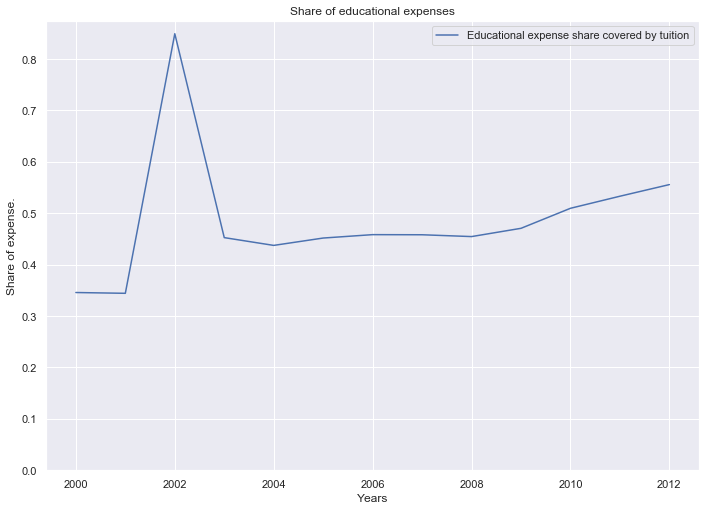

In [56]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = share_exp_trend)
ax.set_title("Share of educational expenses")
ax.set_ylim(0)
ax.set_xlabel("Years")
ax.set_ylabel("Share of expense.")

The trend is interesting. We can see that there was a huge spike in the share in 2002. (Could it be somehow related to the Iraq War? Not sure!) But ignoring that spike, it looks like till 2010, only less than 50% of the tuition revenue was spent on education related expenses. But towards the end, we can see that the share of tuition revenue is slowly rising. Not sure what this means for the future tuition cost trends, but it is good to know that some of the money is coming back around for the student's benefit.

#### Affordability as a function of median household income

This is my final research question:<br/>
** Is college education becoming unaffordable even with the rising median household income?**

Finding the answer to this question, required access to the historical median household income data. I obtained that data from the US census website. It can be obtained [here](https://www.census.gov/data-tools/demo/saipe/saipe.html?s_appName=saipe&map_yearSelector=2017&map_geoSelector=aa_c&s_USStOnly=y&menu=trends&s_measures=mhi_snc&s_inclStTot=y&s_inclUsTot=y). For details regarding the data usage and licensing please refer the Readme.<br/>

After downloading the data, I stored it in the data folder and rename it to `household_income.csv`. The dataset had small issues in its contents, like the household income values were string and not integer type. So I had a bit of datacleaning to complete before I could use this data. And also the state names we spelled out and not in some code format. But the delta cost project had States in codes. So I manually created and stored the state to code mapping file in the data folder (`state_name_code_mapping`). 

In [58]:
# Reading the data
income_df = pd.read_csv('data/household_income.csv',
                        usecols=["Year", "State / County Name", "Median Household Income in Dollars"])
# Cleaning the data to convert the income values to numbers
income_df["Median Household Income in Dollars"] = income_df[
    "Median Household Income in Dollars"].str.replace('$','').str.replace(',','').astype(float)

# Map the State names to US Postal post codes
state_map = pd.read_csv('data/state_name_code_mapping.csv')
income_df = income_df.merge(
    state_map, left_on="State / County Name", right_on="State").drop(
    ["State / County Name","State"], axis=1).rename(columns={'Postal':'state', 'Year':'academicyear'})

Now we have the cleaned data. The affordability of college tuition here is calculated as what portion of the yearly income is that year's avg. tuition. So I first calculated the ratio first. Then I subtracted the fraction from 1 to get the custom affordability measure. I subtracted from one to show affordability as a measure that started at 1 and is slowly going on a downward trend.

In [59]:
# Combining income to form the final dataset.
combined_df = final_df.merge(income_df, on=["state","academicyear"])
# Calculating the affordability of the college tuition
combined_df["affordability"] = 1 - combined_df["adj_avg_tuition"] / combined_df["Median Household Income in Dollars"]
# Calculating the average affordability by year.
aff_trend = combined_df.groupby("academicyear")["affordability"].mean()

Text(0,0.5,'Affordability')

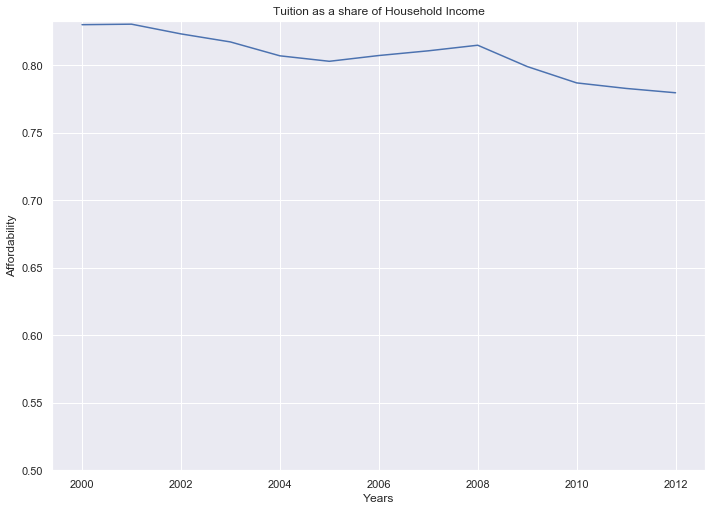

In [61]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(data = aff_trend)
ax.set_title("Tuition as a share of Household Income")
ax.set_ylim(0.5)
ax.set_xlabel("Years")
ax.set_ylabel("Affordability")

So this is the final result of this analysis. We can see that affordability is slowly decreasing over time. The decrease may not seem large at first, but as it continues to decrease, the effects would be felt across the country.

### Conclusion

To conclude, throughout this analysis I explored the trends in tuition costs and several institutional finance characteristics that helped me understand quite a bit about the sources of revenue and its dispersion. I mentioned that I intended to find the answers to three questions and found them:

**Q1. How has the tuition fees risen over the years and what are the factors contributing to it?**
Tuition has been steadily rising over the years, irrespective of the economic situation. From the analysis several factors seemed to have a significant effect on tuition cost trends. They are:
- The number of undergrad students on loan.
- The federal aid per capita
- The avg. income from external sources
- The avg. share of tuition in total revenue

**Q2. Is more money being spend on instruction or for other purposes?**
From what we have seen so far, it is pretty clear that the amount of money being spent on instruction has not increased much, whereas the investment on research has been increasing steadily. Also by observing the share of education expenses covered through tuition, we saw that till 2010 less than 50% of tuition revenue was spent on instructional purposes. It was only since 2010 we saw a rise in utilization of tuition revenue towards educational expenses.

**Q3. Is college education becoming unaffordable even with the rising median household income?**
The answer to this question already quite well known. But I added it to complete the "cycle". The goal of this question was to try and guage the future of college education. From the results we can see that the future does not look good. Even the increasing household income is not able to stay up with the growth in tuition costs. As a result the affordability of a college education is expected to go down. Combining that with increasing saturation in the industry and rising student debts,  paints a bleak picture for those aspiring for a college degree.

### Limitations

- The analysis has only considered undergraduate students and 4 year public institutions. Expanding the base to private and 2 year public institutions could help throw new light to the scenarios.
- The current model is quite simple. Including interaction terms and even more factors might provide more insights on the data.
- The analyisis does not try to tie the observed trends back to the real world triggers like policy changes or economic meltdown etc. Research a bit about that would definitely make things more interesting.

### References
[1] https://studentaid.ed.gov/sa/repay-loans/default <br/>
[2] https://www.studentdebtrelief.us/student-loans/student-debt-statistics/ <br/>
[3] https://www.nber.org/chapters/c13711.pdf <br/>
[4] https://trends.collegeboard.org/college-pricing/figures-tables/average-rates-growth-published-charges-decade <br/>
[5] http://prospect.org/article/argument-tuition-free-college
[6] https://www.cnbc.com/2017/11/29/how-much-college-tuition-has-increased-from-1988-to-2018.html
[7] R. B. Archibald and D. H. Feldman. Explaining increases in higher education costs. The Journal of Higher Education, 2008